Accuracy (SVM): 52.95%


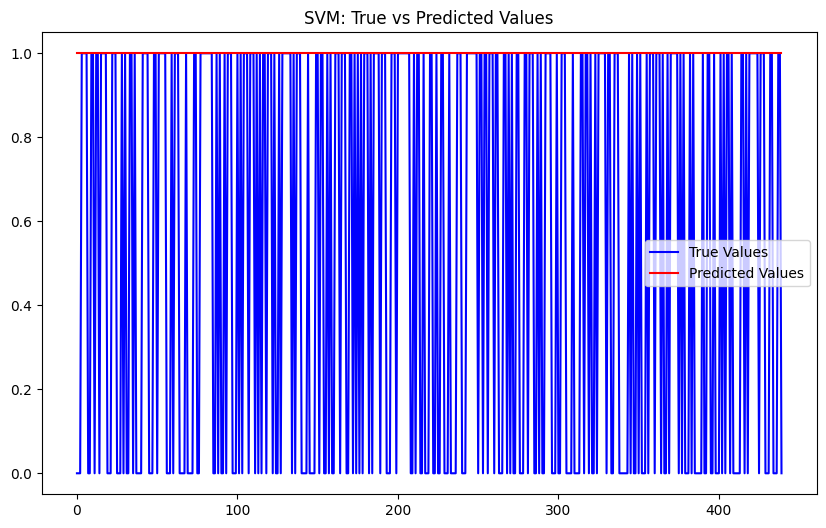

In [2]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Konwersja kolumny 'LogReturn' na klasy (1 dla wzrostu, 0 dla spadku)
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)
data_class['date'] = pd.to_datetime(data_class['date'])

# Filtrujemy dane z lat < 2019
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie cech i zmiennej celu
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Inicjalizacja i trenowanie modelu SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_svm = svm_model.predict(X_test)

# Ocena dokładności
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", color='blue')
plt.plot(y_pred_svm, label="Predicted Values", color='red')
plt.title('SVM: True vs Predicted Values')
plt.legend()
plt.show()


Najlepsze parametry: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Dokładność po optymalizacji: 80.00%
Precision: 81.94%
Recall   : 79.83%
F1-Score : 80.87%


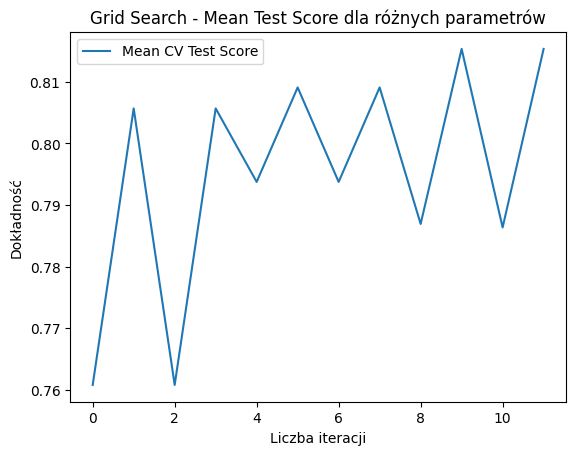

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Tworzenie zmiennej binarnej na podstawie 'LogReturn'
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)

# Konwersja daty na datetime
data_class['date'] = pd.to_datetime(data_class['date'])

# Selekcja danych przed 2019 rokiem
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie cech
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Skalowanie cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Obliczenie wag klas (ważniejsze klasy dostaną większe wagi)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Definicja parametrów dla GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Inicjalizacja i przeprowadzenie GridSearchCV
grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_scaled, y_train)

# Wybór najlepszego modelu
best_model = grid_search.best_estimator_

print(f"Najlepsze parametry: {grid_search.best_params_}")

# Predykcja na zbiorze testowym
X_test_scaled = scaler.transform(X_test)
y_pred = best_model.predict(X_test_scaled)

# Obliczenie dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność po optymalizacji: {accuracy * 100:.2f}%")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1-Score : {f1 * 100:.2f}%")

# Wizualizacja wyników
plt.plot(grid_search.cv_results_['mean_test_score'], label="Mean CV Test Score")
plt.title("Grid Search - Mean Test Score dla różnych parametrów")
plt.xlabel("Liczba iteracji")
plt.ylabel("Dokładność")
plt.legend()
plt.show()


Accuracy (SVM): 80.91%
F1 Score (SVM): 0.82


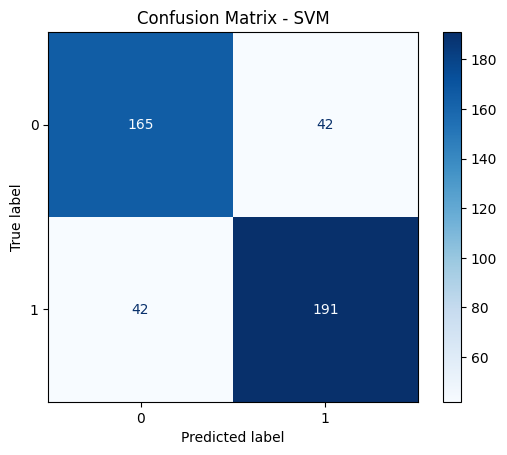

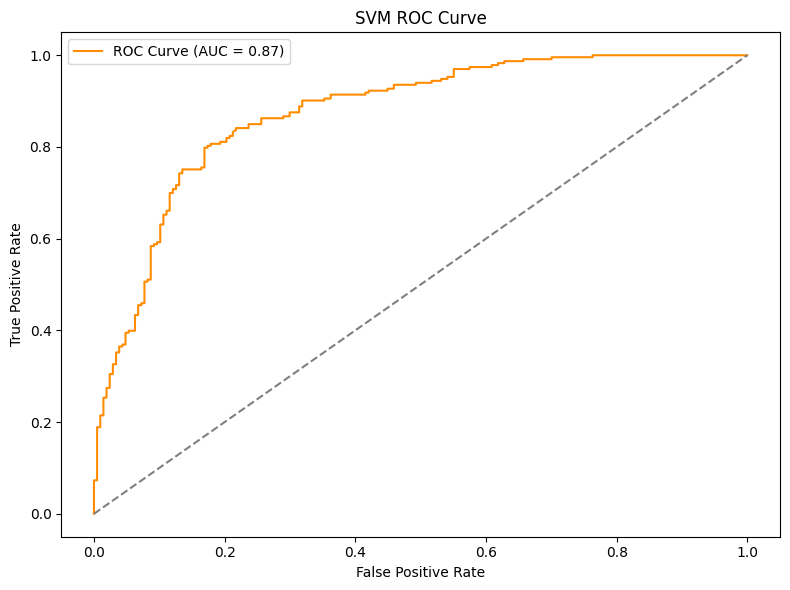

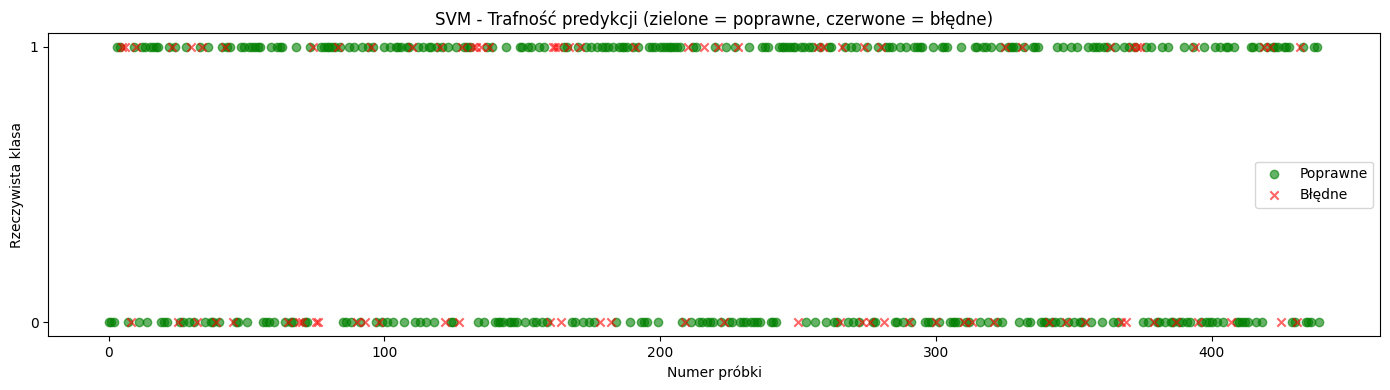

In [41]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Konwersja kolumny 'LogReturn' na klasy (1 dla wzrostu, 0 dla spadku)
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)

# Filtrujemy dane z lat < 2019

# Przygotowanie cech i zmiennej celu
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Skaling danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Inicjalizacja i trenowanie modelu SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight=class_weight_dict, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predykcja
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

# Metryki
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy (SVM): {accuracy * 100:.2f}%")
print(f"F1 Score (SVM): {f1:.2f}")

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Przygotowanie danych do wykresu
true_vals = y_test.values
pred_vals = y_pred

plt.figure(figsize=(14, 4))

# Poprawne predykcje
correct_idx = np.where(true_vals == pred_vals)[0]
incorrect_idx = np.where(true_vals != pred_vals)[0]

plt.scatter(correct_idx, true_vals[correct_idx], color='green', label='Poprawne', alpha=0.6, marker='o')
plt.scatter(incorrect_idx, true_vals[incorrect_idx], color='red', label='Błędne', alpha=0.6, marker='x')

plt.title('SVM - Trafność predykcji (zielone = poprawne, czerwone = błędne)')
plt.xlabel('Numer próbki')
plt.ylabel('Rzeczywista klasa')
plt.yticks([0, 1])
plt.legend()
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Wczytanie danych
data = pd.read_csv('data_final.csv')

# Obliczamy kwartyle
q1 = data['LogReturn'].quantile(0.25)
q2 = data['LogReturn'].quantile(0.50)  # Mediana
q3 = data['LogReturn'].quantile(0.75)

# Tworzymy nowe kolumny klasyfikacji na podstawie kwartyli
def classify_log_return(row):
    if row['LogReturn'] <= q1:
        return 0  # Klasa 0 - pierwszy kwartyl
    elif row['LogReturn'] <= q2:
        return 1  # Klasa 1 - drugi kwartyl
    elif row['LogReturn'] <= q3:
        return 2  # Klasa 2 - trzeci kwartyl
    else:
        return 3  # Klasa 3 - czwarty kwartyl

# Przypisanie klas do danych
data_class4 = data.copy()
data_class4['LogReturn'] = data_class4.apply(classify_log_return, axis=1)
print(np.unique(data_class4['LogReturn']))

# Przygotowanie cech i zmiennej celu
X = data_class4.drop(['LogReturn'], axis=1)
Y = data_class4['LogReturn']

# Skaling danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print(np.unique(y_train))
# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2,3]), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.array([0,1,2,3]), class_weights)}

# Inicjalizacja i trenowanie modelu SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight=class_weight_dict, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predykcja
y_pred = svm_model.predict(X_test)

# Metryki
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # F1 score dla wieloklasowego przypadku

print(f"Accuracy (SVM): {accuracy * 100:.2f}%")
print(f"F1 Score (SVM): {f1:.2f}")
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall   : {recall * 100:.2f}%")


# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)


[0 1 2 3]
[0 1 2 3]
Accuracy (SVM): 57.50%
F1 Score (SVM): 0.58
Recall   : 57.50%
Macierz pomyłek:
[[74 19  4  7]
 [16 65 33 11]
 [ 6 35 47 18]
 [ 1  4 33 67]]
